### Importing the necessary Libraries

In [294]:
import pandas as pd

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Importing the data

In [298]:
df1 = pd.read_csv('C:/Users/ritaf/Documents/GitHub/CP/Capstone/No_show_prediction/medical-appointments-no-show-en.csv')

Taking an initial look at our dataframe

In [299]:
df1.head()
# We have 49593 rows

,specialty,appointment_time,gender,appointment_date,no_show,no_show_reason,disability,date_of_birth,entry_service_date,city,...,over_60_years_old,patient_needs_companion,average_temp_day,average_rain_day,max_temp_day,max_rain_day,rainy_day_before,storm_day_before,rain_intensity,heat_intensity
0,physiotherapy,13:20,M,09/09/2021,yes,surto,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
1,psychotherapy,13:20,M,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
2,speech therapy,13:20,F,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
3,physiotherapy,13:20,F,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
4,physiotherapy,14:00,M,09/09/2021,no,NaN,motor,10/10/1954,5/2/2020,B. CAMBORIU,...,1,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild


Checking for null values

In [300]:
df1.info()
# Temos bastantes nans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49593 entries, 0 to 49592
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   specialty                42139 non-null  object 
 1   appointment_time         49593 non-null  object 
 2   gender                   49593 non-null  object 
 3   appointment_date         49593 non-null  object 
 4   no_show                  49593 non-null  object 
 5   no_show_reason           1737 non-null   object 
 6   disability               44456 non-null  object 
 7   date_of_birth            39272 non-null  object 
 8   entry_service_date       44438 non-null  object 
 9   city                     44412 non-null  object 
 10  icd                      10717 non-null  object 
 11  appointment_month        49593 non-null  object 
 12  appointment_year         49593 non-null  int64  
 13  appointment_shift        49593 non-null  object 
 14  age                   

There are some columns (no_show_reason  and idc) with a high number of invalid values which we will proceed to drop. In addition to that, we will delete columns like the date_of_birth as we already have age and appointment_shift as we already have the appointment time

In [301]:
df1.drop(['no_show_reason', 'icd', 'date_of_birth', 'appointment_shift'], axis = 1, inplace = True)
# ICD é o código da doença

Dropping the remaining null values from the remaining columns

In [327]:
df1.dropna(inplace = True)
# ficamos com 34607 rows (dropamos 14986)

In [328]:
df1 # ALGO MUDOU... PORQUE?

,specialty,appointment_time,gender,disability,city,appointment_month,appointment_year,age,under_12_years_old,over_60_years_old,...,max_temp_day,max_rain_day,rainy_day_before,storm_day_before,rain_intensity,heat_intensity,distances (km),recency,appointment_day,showed_up
4,physiotherapy,14.0,0.0,motor,B. CAMBORIU,9,2021,68.0,0,1,...,23.7,0.2,1,1,0,0,12.3,1383,9,1
5,occupational therapy,14.0,0.0,intellectual,ITAJAÍ,9,2021,5.0,1,0,...,23.7,0.2,1,1,0,0,2.4,1454,9,1
6,psychotherapy,14.0,0.0,intellectual,CAMBORIU,9,2021,11.0,1,0,...,23.7,0.2,1,1,0,0,14.2,1510,9,1
8,occupational therapy,14.0,0.0,intellectual,ITAJAÍ,9,2021,5.0,1,0,...,23.7,0.2,1,1,0,0,2.4,1460,9,1
11,physiotherapy,14.7,1.0,motor,NAVEGANTES,9,2021,28.0,0,0,...,23.7,0.2,1,1,0,0,6.3,1244,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49552,occupational therapy,17.0,0.0,motor,ITAJAÍ,3,2021,23.0,0,0,...,24.6,32.8,1,1,3,0,2.4,1147,1,1
49554,speech therapy,17.0,1.0,motor,ITAJAÍ,3,2021,68.0,0,1,...,24.6,32.8,1,1,3,0,2.4,1558,1,1
49556,physiotherapy,17.7,1.0,motor,ITAJAÍ,3,2021,68.0,0,1,...,24.6,32.8,1,1,3,0,2.4,1558,1,1
49557,occupational therapy,17.7,1.0,intellectual,BALN. PIÇARRAS,3,2021,5.0,1,0,...,24.6,32.8,1,1,3,0,26.3,1553,1,1


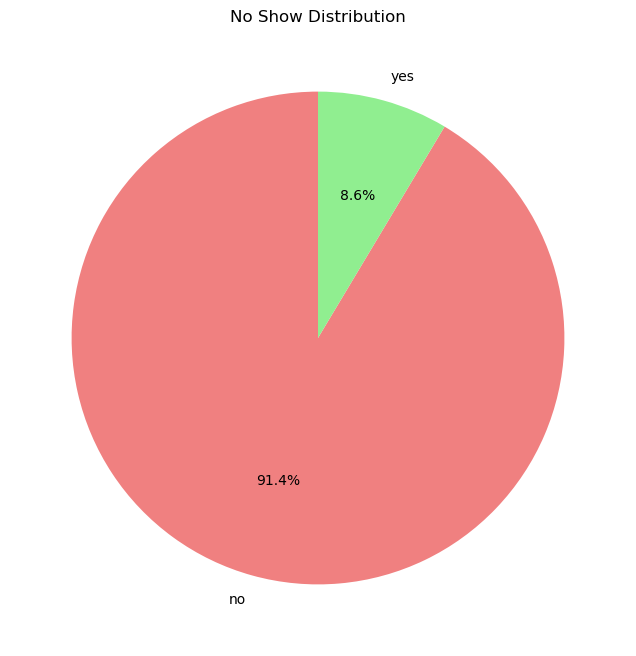

In [303]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df1 is your DataFrame
# Assuming 'no_show' is the column containing 'Yes' and 'No'
no_show_counts = df1['no_show'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(no_show_counts, labels=no_show_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title('No Show Distribution')
plt.show()


In [304]:
df1.city.unique()

array(['B. CAMBORIU', 'ITAJAÍ', 'CAMBORIU', 'NAVEGANTES', 'ILHOTA',
       'BOMBINHAS', 'ITAPEMA', 'PORTO BELO', 'PENHA', 'LUIZ ALVES',
       'BALN. PIÇARRAS'], dtype=object)

In [305]:
distances = {'B. CAMBORIU': 12.3,
             'ITAJAÍ': 2.4,
             'CAMBORIU': 14.2,
             'NAVEGANTES': 6.3,
             'ILHOTA': 23,
             'BOMBINHAS': 49.1,
             'ITAPEMA': 27.1,
             'PORTO BELO': 39.3,
             'PENHA': 28,
             'LUIZ ALVES': 44,
             'BALN. PIÇARRAS': 26.3
          }

In [306]:
df1['distances (km)'] = df1['city'].map(distances)

In [307]:
# transforma horas em floats
df1['appointment_time'] = df1['appointment_time'].apply(lambda x: round(int(x.split(':')[0]) + int(x.split(':')[1]) / 60, 1))


In [308]:
df1['entry_service_date'] = pd.to_datetime(df1['entry_service_date'], format='%d/%m/%Y', errors='coerce')
df1 = df1.dropna(subset=['entry_service_date'])

In [309]:
#df1['entry_service_date'] = pd.to_datetime(df1['entry_service_date'], format='%d/%m/%Y')
df1['recency'] = pd.to_datetime('now') - pd.to_datetime(df1['entry_service_date'])
df1['recency'] = df1['recency'].dt.days

In [310]:
#check if recency is correct
#df1['recency'].unique()

In [311]:
df1.isna().any()
# now we don't have any nans

specialty                  False
appointment_time           False
gender                     False
appointment_date           False
no_show                    False
disability                 False
entry_service_date         False
city                       False
appointment_month          False
appointment_year           False
age                        False
under_12_years_old         False
over_60_years_old          False
patient_needs_companion    False
average_temp_day           False
average_rain_day           False
max_temp_day               False
max_rain_day               False
rainy_day_before           False
storm_day_before           False
rain_intensity             False
heat_intensity             False
distances (km)             False
recency                    False
dtype: bool

In [312]:
df1.drop('entry_service_date', axis = 1, inplace = True)
# now we can drop the entry_service_date column as we have the recency column

In [313]:
df1.T

,4,5,6,8,11,12,13,14,16,18,...,49546,49547,49549,49550,49551,49552,49554,49556,49557,49558
specialty,physiotherapy,occupational therapy,psychotherapy,occupational therapy,physiotherapy,occupational therapy,psychotherapy,psychotherapy,speech therapy,physiotherapy,...,speech therapy,speech therapy,occupational therapy,psychotherapy,psychotherapy,occupational therapy,speech therapy,physiotherapy,occupational therapy,psychotherapy
appointment_time,14.0,14.0,14.0,14.0,14.7,14.7,14.7,14.7,14.7,15.3,...,16.3,16.3,17.0,17.0,17.0,17.0,17.0,17.7,17.7,17.7
gender,M,M,M,M,F,M,M,F,M,M,...,F,F,F,F,F,M,F,F,F,M
appointment_date,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,...,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021
no_show,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
disability,motor,intellectual,intellectual,intellectual,motor,motor,intellectual,intellectual,intellectual,motor,...,intellectual,intellectual,intellectual,intellectual,intellectual,motor,motor,motor,intellectual,motor
city,B. CAMBORIU,ITAJAÍ,CAMBORIU,ITAJAÍ,NAVEGANTES,B. CAMBORIU,ITAJAÍ,ILHOTA,ITAJAÍ,BOMBINHAS,...,BALN. PIÇARRAS,ITAPEMA,ITAPEMA,ITAPEMA,BALN. PIÇARRAS,ITAJAÍ,ITAJAÍ,ITAJAÍ,BALN. PIÇARRAS,ITAJAÍ
appointment_month,sept,sept,sept,sept,sept,sept,sept,sept,sept,sept,...,mar,mar,mar,mar,mar,mar,mar,mar,mar,mar
appointment_year,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
age,68.0,5.0,11.0,5.0,28.0,68.0,5.0,9.0,5.0,25.0,...,5.0,9.0,9.0,9.0,5.0,23.0,68.0,68.0,5.0,23.0


In [314]:
# creating the day of appointment column, since we already have the month and year columns
df1['appointment_day'] = pd.to_datetime(df1['appointment_date'], format='%d/%m/%Y').dt.day

In [315]:
# we can now drop the appointment_date column
df1.drop('appointment_date', axis=1, inplace = True)

In [316]:
df1.appointment_month.unique()

array(['sept', 'aug', 'july', 'june', 'may', 'april', 'mar', 'feb', 'dec',
       'nov', 'oct', 'jan'], dtype=object)

In [317]:
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3,
                 'april': 4, 'may': 5, 'june': 6, 'july': 7, 'aug': 8,
                 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12}

In [318]:
df1['appointment_month'] = df1['appointment_month'].map(month_mapping)


In [320]:
temperature_mapping = {'heavy_cold': -2, 'cold': -1, 'mild': 0, 'warm': 1, 'heavy_warm': 2}
df1['heat_intensity'] = df1['heat_intensity'].map(temperature_mapping)

In [322]:
rainfall_mapping = {'no_rain': 0, 'weak': 1, 'moderate': 2, 'heavy': 3}
df1['rain_intensity'] = df1['rain_intensity'].map(rainfall_mapping)

In [321]:
gender_mapping = {'M': 0, 'F': 1}
df1['gender'] = df1['gender'].map(gender_mapping)

In [325]:
noshow_mapping = {'yes': 0, 'no': 1}
df1['showed_up'] = df1['no_show'].map(noshow_mapping)
df1.drop('no_show', axis = 1, inplace = True)
# mudar de no show para showed up para ser mais intuitivo